# Entrono #

In [50]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [51]:
# ----------------------------
# Pub/Sub Broker
# ----------------------------
class PubSubBroker:
    def __init__(self):
        self.subscribers = []

    def subscribe(self, callback):
        self.subscribers.append(callback)

    def publish(self, data):
        for callback in self.subscribers:
            callback(data)

# ----------------------------
# Whiteboard (memoria compartida)
# ----------------------------
class Whiteboard:
    def __init__(self):
        self.data = {}

    def write(self, key, value):
        self.data[key] = value

    def read(self):
        while len(self.data) < 2:
            print("Esperando datos en la pizarra... ", self.data)
            time.sleep(5)
        return dict(self.data)

    def clear(self):
        self.data = {}

# ----------------------------
# DataFetcher (Insertar agente de recolección de datos)
# ----------------------------
class DataFetcher:
    def __init__(self, dataframe):
        self.df = dataframe
        self.index = 0

    def has_next(self):
        return self.index < len(self.df)
    
    def get_next_ticker(self):
        if self.index < len(self.df):
            return self.df.iloc[self.index]['Ticker']
        return None

    def fetch_data(self):
        current = self.df.loc[self.index]
        self.index += 1
        return current
# ----------------------------

In [52]:
class traditionalAgent:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.broker = broker
        self.whiteboard = whiteboard
        self.broker.subscribe(self.group_traditional)
        self.data_fetcher = data_fetcher

    def group_traditional(self, data):
        if self.data_fetcher.index > 1:
            last_close = df.loc[self.data_fetcher.index - 2]['Close']
        else:
            last_close = data['Close']
        pred1 = last_close * random.uniform(0.97, 1.03)
        pred2 = last_close * random.uniform(0.97, 1.03)
        avg = (pred1 + pred2) / 2
        self.whiteboard.write('trad_pred', avg)
        
    def set_dataframe():
        self.df = self.df

In [53]:
class agenteIA:
    def __init__(self, broker, whiteboard, data_fetcher):
        self.broker = broker
        self.whiteboard = whiteboard
        self.broker.subscribe(self.group_ai)
        self.data_fetcher = data_fetcher

    def group_ai(self, data):
        if self.data_fetcher.index > 1:
            last_close = df.loc[self.data_fetcher.index - 2]['Close']
        else:
            last_close = data['Close']
        pred1 = last_close * random.uniform(0.95, 1.05)
        pred2 = last_close * random.uniform(0.95, 1.05)
        avg = (pred1 + pred2) / 2
        self.whiteboard.write('ai_pred', avg)
        
    def set_dataframe():
        self.df = self.df

In [63]:
# ----------------------------
# MarketEnvironment
# ----------------------------
class MarketEnvironment:
    def __init__(self, df):
        self.df = df
        self.data_fetcher = DataFetcher(df)
        self.broker = PubSubBroker()
        self.whiteboard = Whiteboard()
        self.histories = {}  # Diccionario para almacenar cada empresa

        # Agentes de predicción
        self.agentsTraditional = traditionalAgent(self.broker, self.whiteboard, self.data_fetcher)
        self.agentsIA = agenteIA(self.broker, self.whiteboard, self.data_fetcher)

        # Suscribir los grupos de agentes al broker
        self.broker.subscribe(self.agentsTraditional.group_traditional)
        self.broker.subscribe(self.agentsIA.group_ai)

    def run(self):
        tickers = self.df['Ticker'].unique().tolist()
        for ticker in tickers:
            self.histories[ticker] = pd.DataFrame(columns=['Datetime', 'Real_Close', 'Trad_Prediction', 'AI_Prediction'])

            while self.data_fetcher.has_next():
                data = self.data_fetcher.fetch_data()
                self.whiteboard.clear()
                self.broker.publish(data)

                results = self.whiteboard.read()

                self.histories[ticker].loc[len(self.histories[ticker])] = [
                    data['Datetime'],
                    data['Close'],
                    results.get('trad_pred', data['Close']),
                    results.get('ai_pred', data['Close'])
                ]
                if self.data_fetcher.get_next_ticker() != ticker:
                    break
            # Cuando termina un ticker, genera la gráfica completa
            self.plot_graph(ticker)

            # Guarda el Excel de ese ticker
            self.histories[ticker].to_excel(f'simulacion_{ticker}.xlsx', index=False)

            print(f"Terminó {ticker}, el siguiente es {self.data_fetcher.get_next_ticker()}")


    def plot_graph(self, ticker):
        history = self.histories[ticker]

        plt.figure(figsize=(12,5))
        plt.plot(history['Datetime'], history['Real_Close'], label='Precio Real', marker='o')
        plt.plot(history['Datetime'], history['Trad_Prediction'], label='Predicción Tradicional', linestyle='--', marker='x')
        plt.plot(history['Datetime'], history['AI_Prediction'], label='Predicción IA', linestyle='-.', marker='s')
        plt.legend()
        plt.title(f'Simulación Multiagente - {ticker}')
        plt.xlabel('Tiempo')
        plt.ylabel('Precio de Cierre')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


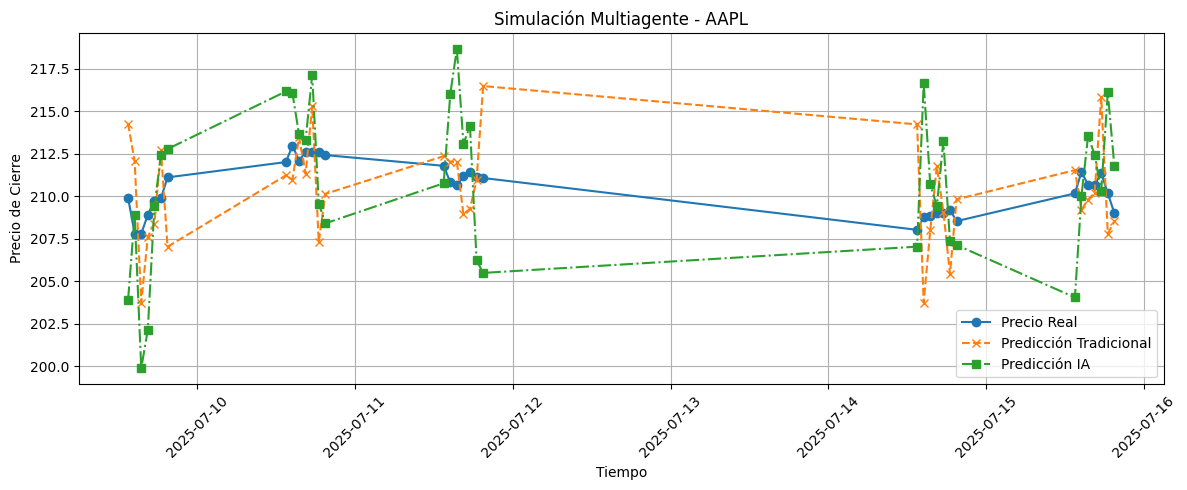

Terminó AAPL, el siguiente es MSFT


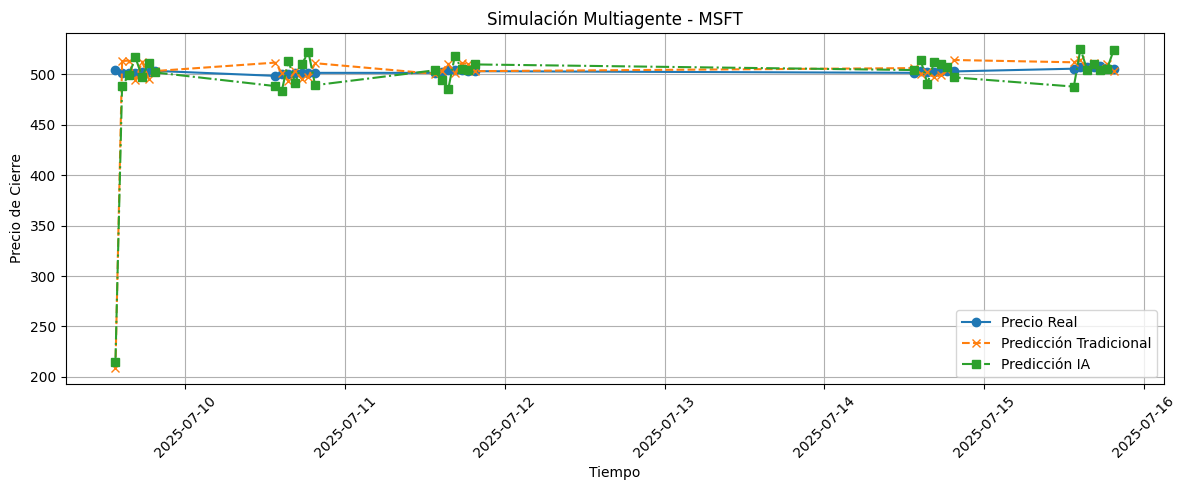

Terminó MSFT, el siguiente es GOOGL


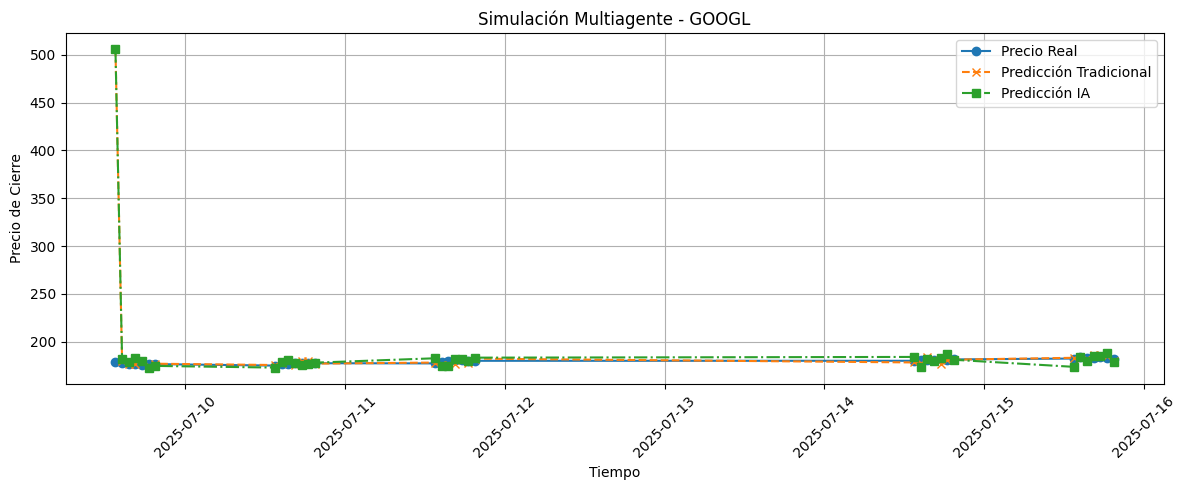

Terminó GOOGL, el siguiente es AMZN


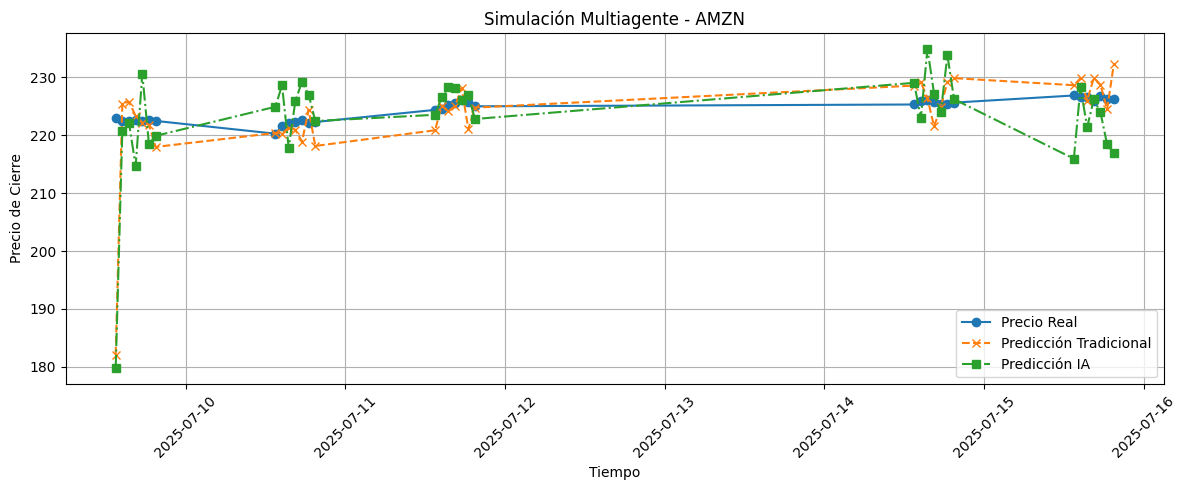

Terminó AMZN, el siguiente es NVDA


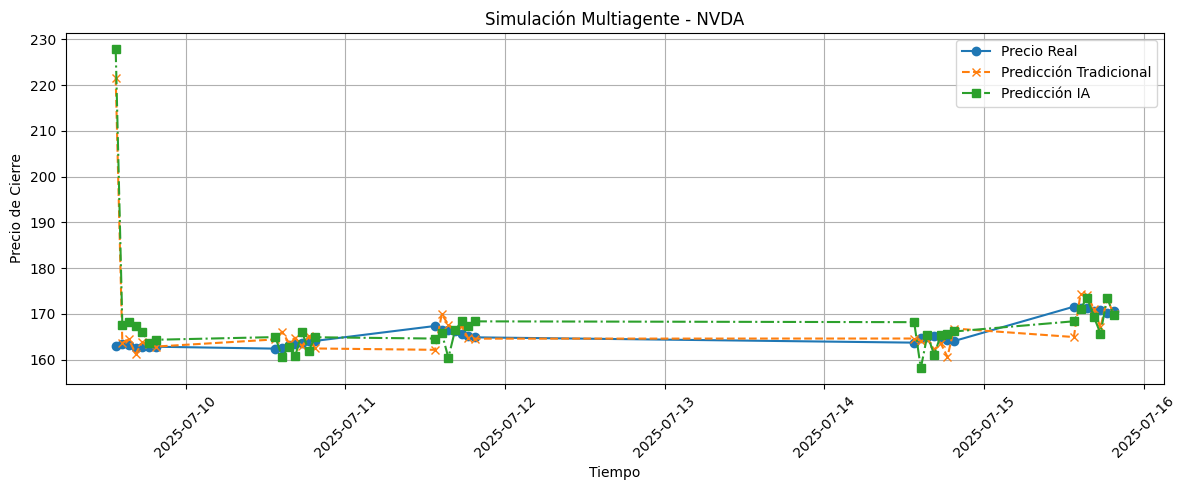

Terminó NVDA, el siguiente es META


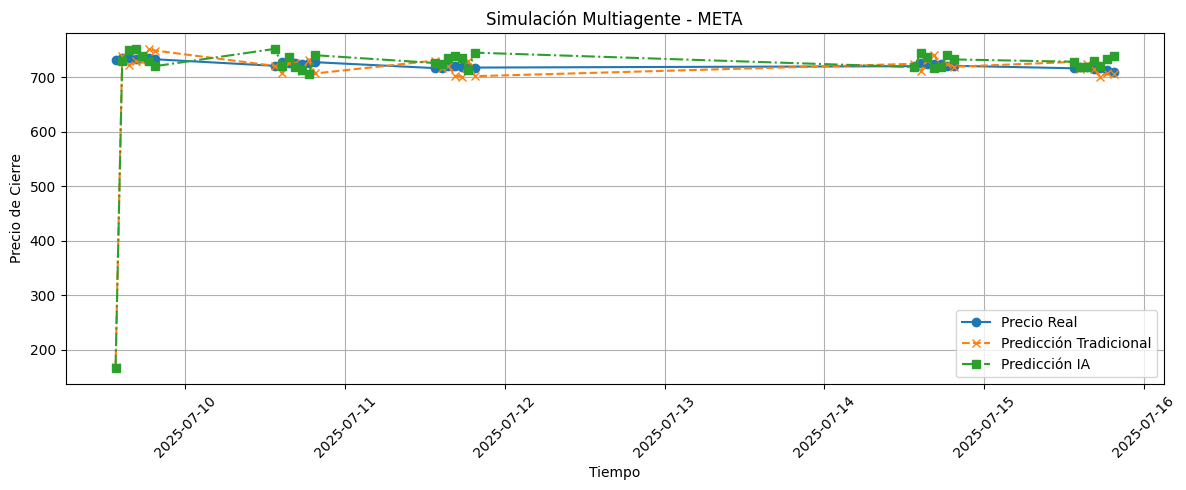

Terminó META, el siguiente es BRK-B


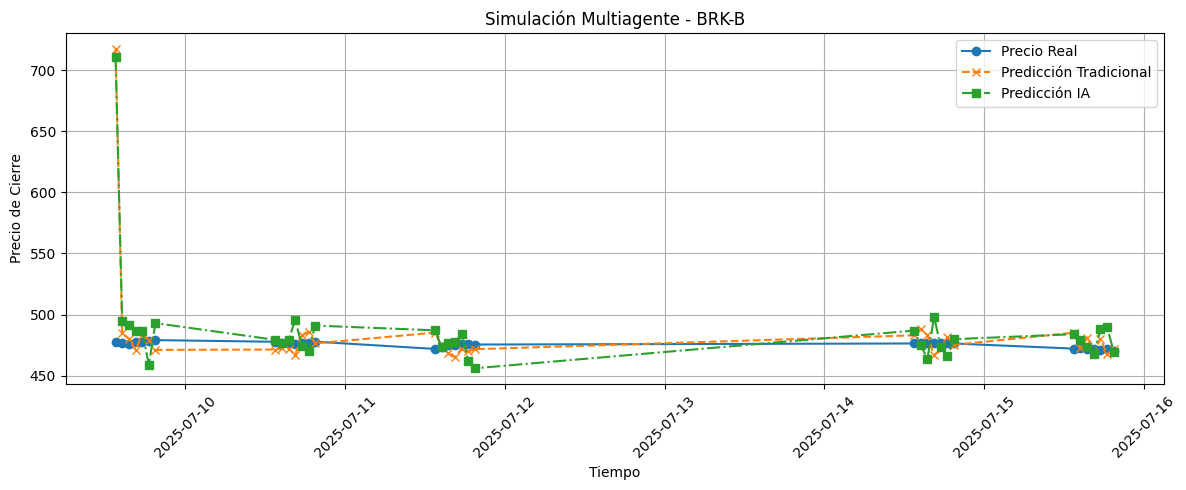

Terminó BRK-B, el siguiente es TSLA


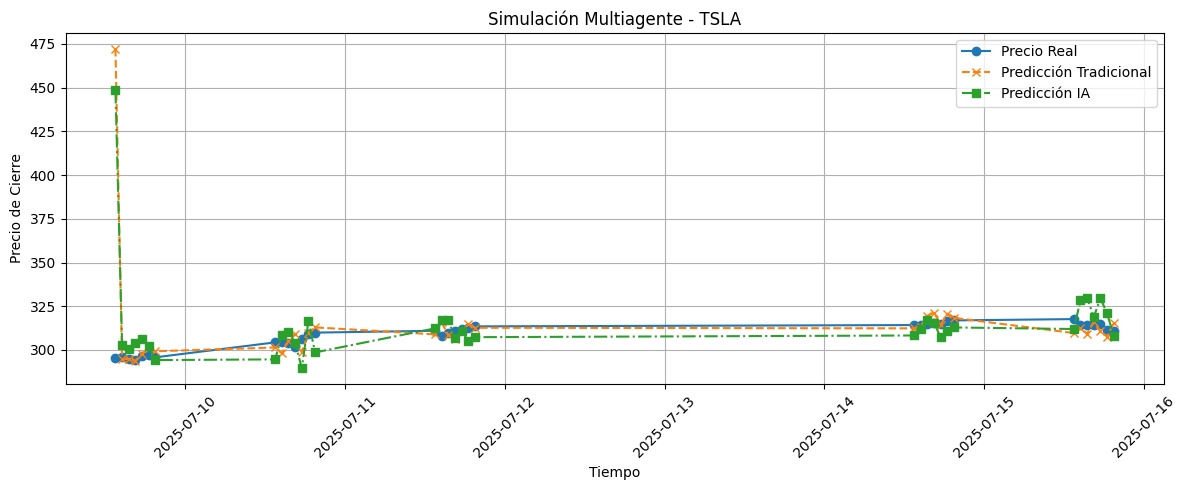

Terminó TSLA, el siguiente es TSM


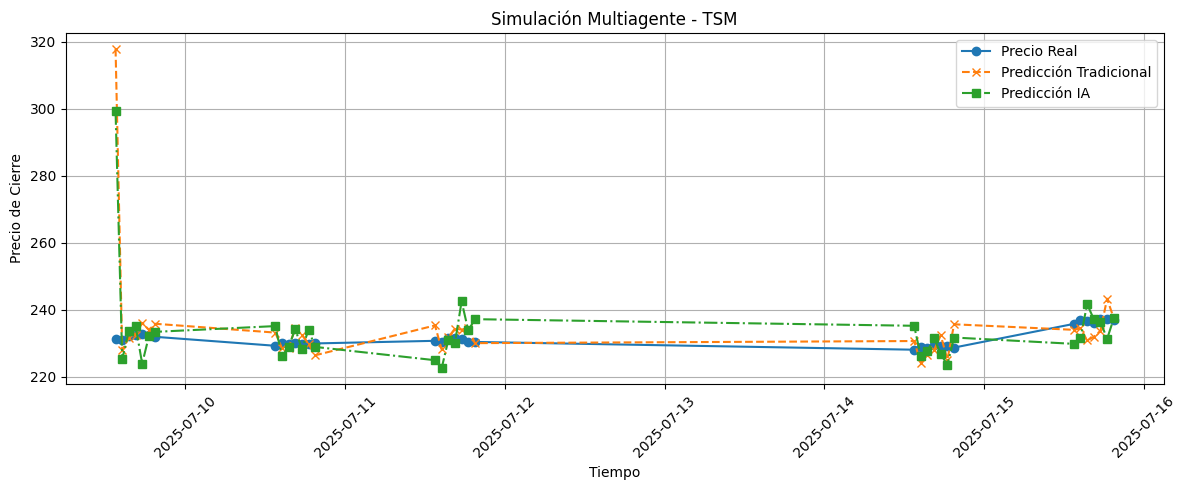

Terminó TSM, el siguiente es JPM


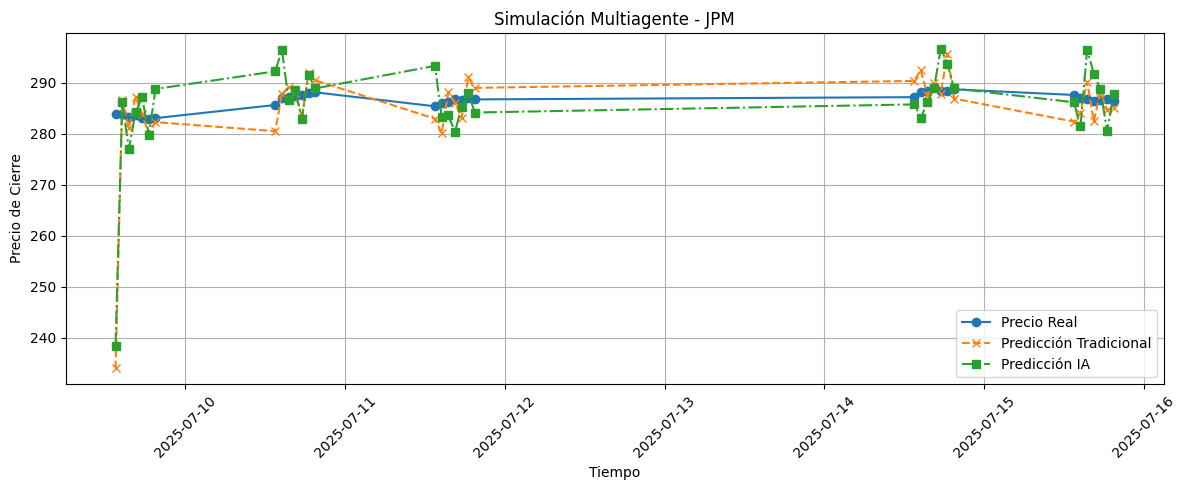

Terminó JPM, el siguiente es None


In [64]:
# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    # Cargar datos
    df = pd.read_excel("historico_top10_indicadores_completos.xlsx")
    env = MarketEnvironment(df)
    env.run()